In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import circ
import slabrup

In [2]:
dump_hik = slabrup.get_GeoNetevents('hik')
dump_puy = slabrup.get_GeoNetevents('puy')
slabevents = {'hik': dump_hik, 'puy': dump_puy}

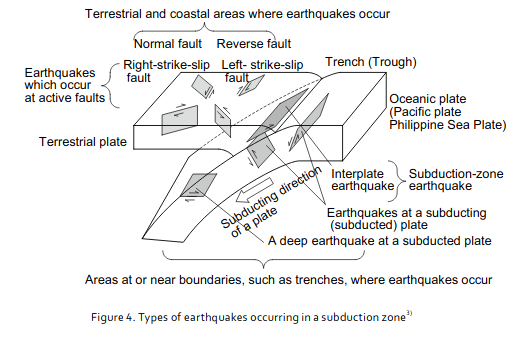

https://www.jaso.jp/pdf/earthquake_resistant.pdf

In [3]:
critical_dip = {'hik': 30, 'puy': 30}
# trnsition dip for strike-chnage
# process_strikediprake(slabevents, szone, critical_dip=None):
dump_hik = slabrup.process_strikediprake(slabevents, 'hik', critical_dip=critical_dip)
dump_puy = slabrup.process_strikediprake(slabevents, 'puy', critical_dip=critical_dip)
procslabevents  = {'hik': dump_hik, 'puy': dump_puy,}

print(len(slabevents['hik']['strike1']))
print(len(slabevents['puy']['strike1']))

399
76


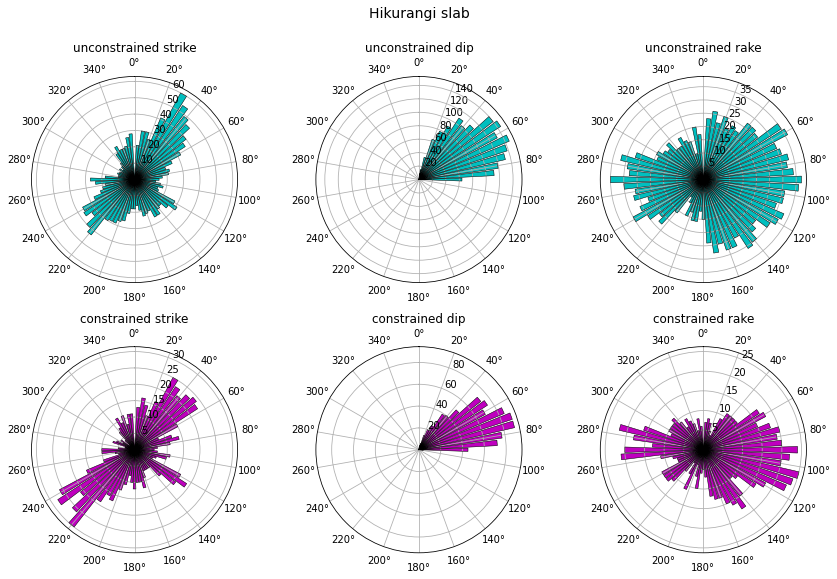

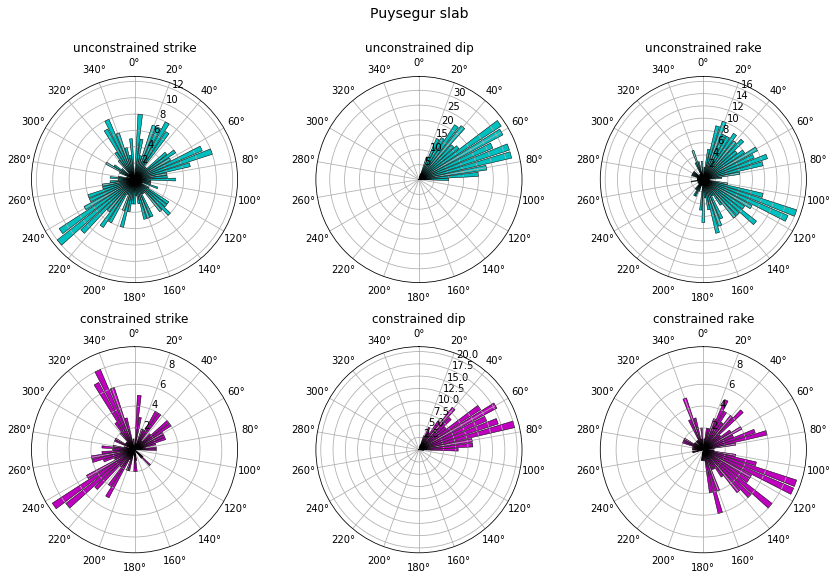

In [4]:
# let us see how the strike, dip & rakes looks like
dump_hik = slabrup.get_allstrikediprakes(slabevents, 'hik')
dump_puy = slabrup.get_allstrikediprakes(slabevents, 'puy')
xslabevents = {'hik': dump_hik, 'puy': dump_puy}

slabrup.review_strikediprake(xslabevents, procslabevents, 'hik')
plt.show()
slabrup.review_strikediprake(xslabevents, procslabevents, 'puy')

In [5]:
def binned_strikes(x, y, fbs =10, min_x = 20, max_x = 300, doplot=True,
                       strtitle='', xlabel='depth (km)', ylabel = '', ax = None):
    # plot y according to binnned x
    x_bin = [d for d in range(min_x, max_x, fbs)]
    xbox  ={}
    x_means, x_std = [], []
    
    for xb in x_bin:
        kx =[]
        for xx, yy in zip(x, y):
            if (xx>=(xb-fbs)) & (xx<(xb+fbs)):
                kx.append(yy)
        if len(kx)<4:
            x_means.append(float("nan"))
            x_std.append(float("nan"))
        else:
            cmean, cstd = circ.meanstats(kx, high=360, stdev=True)
            x_means.append(cmean)
            x_std.append(cstd)
       #  x_val.append(xb)
    # returns mean, mean+std, mean-std
        xbox.update({xb:kx})
    if doplot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(17,2))
          
        X = range(1, len(x_bin)+1)
        ax.errorbar(X, x_means, color = 'k', xerr = None, linewidth= 0.5,
                    yerr = x_std, ls='none', markerfacecolor='none', 
                     capsize=5)
        ax.plot(X,x_means,'ko', markersize=10)
        #for dat,x in zip(data,X):
        #  plt.text(x,70, str(len(dat)))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_yticks([30, 140, 250, 360])
        ax.set_xticks([x for x in X])
        ax.set_xticklabels([str(xx) for xx in x_bin])
        ax.set_title(strtitle, fontsize=13)
        ax.set_xlim([0.5, len(X)+0.5])
    return xbox

In [11]:
from scipy.interpolate import interp1d
from scipy.interpolate import PPoly

def evalute_strikediprake_depbin(szone, xslabevents):
    stitle = {'hik': 'Hikurangi Slab', 'puy': 'Puysegur slab'}
    
    if szone=='hik': 
        fbs, min_x,max_x  =10, 20, 300
    else:
        fbs, min_x,max_x  =10, 20, 200
        
    fig = plt.figure(1, figsize=(13,8))
    ax1 = fig.add_subplot(311)
    xbox_strike = binned_strikes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['strike'], fbs =fbs, min_x = min_x, max_x = max_x,
                        strtitle='', ylabel='strike (deg)', ax =ax1);
    ax2 = fig.add_subplot(312)
    xbox_dip = slabrup.binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['dip'], fbs =fbs, min_x = min_x, max_x = max_x,
                        strtitle='', ylabel='dip (deg)', ax =ax2);
    ax3 = fig.add_subplot(313)
    slabrup.binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['rake'],fbs =fbs, min_x = min_x, max_x = max_x,
                         strtitle='', ylabel='rake (deg)', ax=ax3);
    fig.suptitle(stitle[szone], fontsize=12, y=0.97) 
    
    
        
    x_bin = [d for d in range(min_x, max_x, fbs)]
    
    X, Y, Ystd = [], [],[] 
    for db in xbox_strike.keys():
        ky = xbox_strike[db]
        if len(ky)<5:
            continue
        cmean, cstd = circ.meanstats(ky, high=360, stdev=True)
        Y.append(cmean)
        Ystd.append(cstd)
        X.append(db)
    if szone =='puy':
        Y.append(cmean)
        Ystd.append(cstd)
        X.append(290)
    X = np.array(X)
    
    strike_interp = interp1d(X, np.array(Y))
    strikestd_interp = interp1d(X, np.array(Ystd))
    bstrikes = []
    
    for db in x_bin:
        bstrikes.append([db, round(strike_interp(db).tolist()), round(strikestd_interp(db).tolist())])
    tS = np.array(bstrikes)
    ax1.errorbar([x  for x in range(1,len(x_bin)+1)], tS[:,1], ls= '--',
                 yerr = tS[:,2], color='g', linewidth=0.2, capsize=5)
    X, Y1 = [], []
    
    for db in xbox_dip.keys():
        ky = xbox_dip[db]
        if len(ky)<5:
            continue
        mean_dip = np.median(ky)
        Y1.append(mean_dip)
        X.append(db)
    if szone =='puy':
        Y1.append(60)
        X.append(60)
        Y1.append(mean_dip)
        X.append(290)
        
    X = np.array(X)
    dip_interp = interp1d(X, np.array(Y1))
    bdips = []
    for db in x_bin:
        bdips.append([db, dip_interp(db).tolist()])
    tS = np.array(bdips)
    ax2.plot([x  for x in range(1,len(x_bin)+1)], tS[:,1], '--', color='g', linewidth=0.5)
    
            
    slabrupgeom = {szone: {'strike': bstrikes, 'dip': bdips}}
    fig.tight_layout()
    return slabrupgeom
    

ValueError: A value in x_new is above the interpolation range.

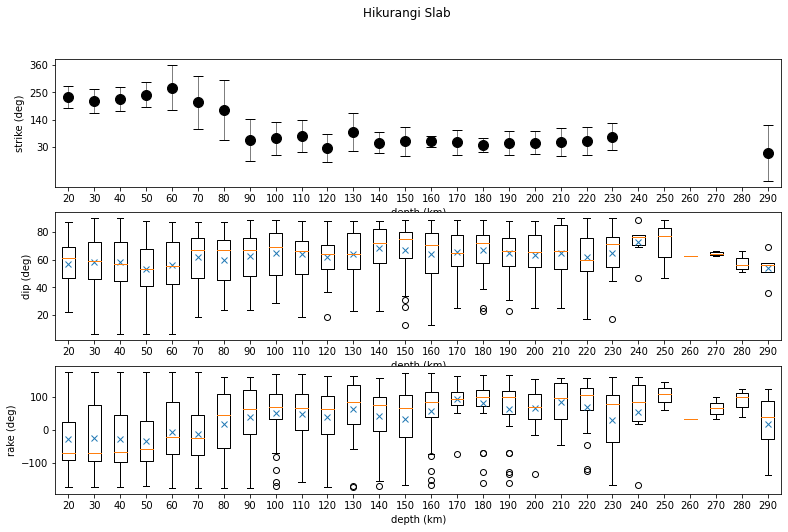

In [12]:
slabrupgeom_hik = evalute_strikediprake_depbin('hik', procslabevents);

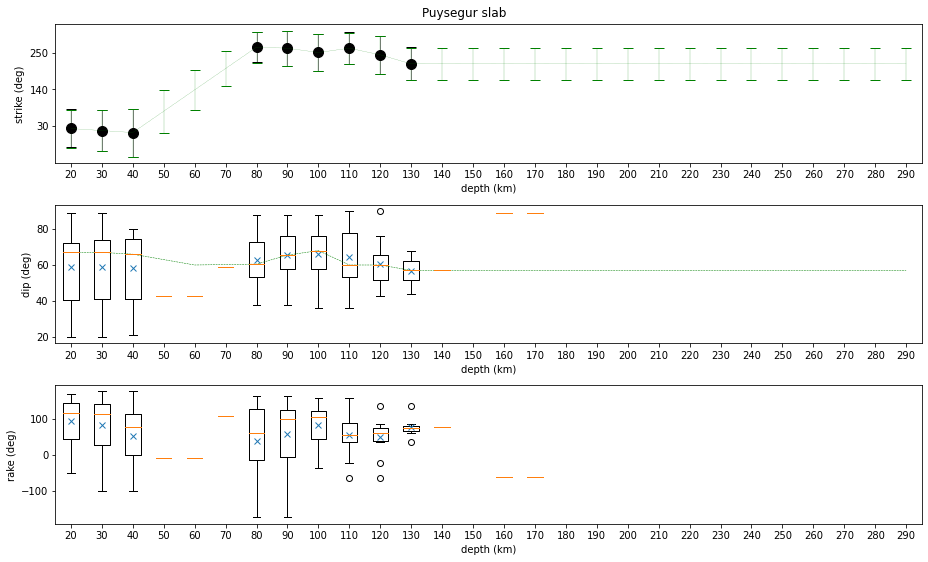

In [10]:
slabrupgeom_puy = evalute_strikediprake_depbin('puy', procslabevents);

In [ ]:
slabrupgeom = {'hik': slabrupgeom_hik, 'puy': slabrupgeom_puy}
import json
with open("slabrupgeom.json", "w") as f:
    json.dump(slabrupgeom, f) 
    

print(slabrupgeom)